In [1]:
import pandas as pd
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from IPython.display import HTML
from vespa.application import Vespa
import torch.nn.functional as F

/home/shogo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_colwidth = 1000

In [3]:
images_root = "../dataset/images/small"

In [4]:
df = pd.read_csv("../output/dataset.tsv", sep="\t")

In [5]:
df.head()

,item_id,item_name_en_us,path
0,B074J5TWYL,"365 Everyday Value, Organic Black Tea (70 Tea Bags), 4.9 oz",03/03fde183.jpg
1,B019OL9E02,Otterbox Symmetry Series iPhone 6/6s Case and AmazonBasics Lightning Cable (6-Feet) Pack,29/291959a2.jpg
2,B0832ZNTS4,"Fresh Brand – Mixed Squash Spirals, 14 oz",51/51c21968.jpg
3,B07PXFVNXR,"Ameriwood Home Classic 5 Drawer Dresser, White",19/19196356.jpg
4,B07KG3F83Z,"Whole Foods Market, Triple Milled Soap, Sandalwood, Highly Moisturizing, 5 oz",d9/d9f07a0a.jpg


In [6]:
app = Vespa(url="http://localhost",port=8080)

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
model.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


# 入力: 検索キーワード

In [8]:
def text_search(text, target_field, ranking, target_hits=100):
    inputs = processor(text=text, return_tensors="pt", padding=True).to(device)
    query_embedding = model.get_text_features(**inputs).reshape(-1).tolist()
    yql = f"select * from item where {{targetHits:{target_hits}, approximate:true}}nearestNeighbor({target_field}, query_embedding)"

    with app.syncio() as session:
        response = session.query(
            yql=yql,
            ranking=ranking,
            body = {
                "input.query(query_embedding)": query_embedding
            }
        )
    return response

In [9]:
def show_hits(response):
    df = pd.DataFrame(response.json["root"]["children"])

    df_out = pd.DataFrame.from_records(df["fields"].values)
    df_out["relevance"] = df["relevance"]
    df_out["image_html"] = '<img width="80" src="' + images_root + "/" +  df_out["path"] + '"/>'
    return HTML(df_out[["item_id", "item_name_en_us", "relevance", "image_html"]].to_html(escape=False))

In [10]:
response = text_search("short modern cabinet", "image_embedding", "image_embedding_closeness")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B0853Q7C48,"Amazon Brand – Rivet Mid-Century Modern Pine Bar Cabinet, 31.5""W, Brown",0.434992,
1,B07QD6V13M,"Amazon Brand – Rivet Modern Media Storage Cabinet, 31.5""W, White",0.434035,
2,B07SRCS9TG,Amazon Brand - Solimo Vega Engineered Wood 2 Door Wardrobe with Drawer (Espresso Finish),0.433409,
3,B07SWNVDVQ,Amazon Brand - Solimo Vega Engineered Wood 2 Door Wardrobe with Half Mirror (Espresso Finish),0.432827,
4,B072ZK8897,"Amazon Brand – Rivet Modern Lacquer and Wood Cabinet, 23.6""L, Glossy White and Wood",0.432401,
5,B082L28P18,"Amazon Brand – Stone & Beam Modern 2-Drawer File Cabinet with Recessed Metal Handles, 28.5""H, White",0.431994,
6,B07QF9ZFQZ,"Amazon Brand – Rivet Campbell Mid-Century Media Console with Tapered Legs, 47""W, Dark Wood and White",0.431966,
7,B07QD6V1S4,"Amazon Brand – Ravenna Home Classic Glass-Doored Media Storage Cabinet, 31.5""W, White",0.431850,
8,B07QJLJRWW,"Amazon Brand – Rivet Campbell Mid-Century Media Console with Tapered Legs, 20""W, Pale Wood and White",0.431785,
9,B07QHKJP7P,"Amazon Brand – Rivet Arbor Mid-Century Media Console with Tapered Legs, 39""W, White",0.431486,


In [11]:
response = text_search("black short modern cabinet", "image_embedding", "image_embedding_closeness")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B07MM487QZ,"Amazon Brand – Ravenna Home Solid Pine Flat-Topped Headboard - Queen, 65 Inch, Black",0.435942,
1,B07Q3XCKNB,"AmazonBasics Classic Wardrobe Cabinet/Portable Closet - 32-Inch, Cappuccino",0.435275,
2,B07SWNVDVQ,Amazon Brand - Solimo Vega Engineered Wood 2 Door Wardrobe with Half Mirror (Espresso Finish),0.434979,
3,B07HSDP2CP,"Amazon Brand – Rivet Modern Chest of Drawers with Diamond Pattern 17.3""W, Walnut & Gray Wash",0.434234,
4,B07RD7P3CV,Amazon Brand - Solimo Zeus Engineered Wood Bedside Table (Wenge Finish),0.433901,
5,B07P6QB29Y,"AmazonBasics Classic 70"" Wood TV Stand with Storage Console, Black Oak",0.433305,
6,B07MCCRYNR,"Amazon Brand – Ravenna Home Classic Media Center with Glass-Front Cabinets, 44""W, Black Wood",0.433262,
7,B07HSKW3D6,"Amazon Brand – Rivet Stevens Modern Wood TV Media Center Cabinet, 51.18""W, Brushed Tundra Gray",0.433159,
8,B07P7VBMKP,AmazonBasics Modern 50-Inch Wood TV Console and Cube Organizer - Solid Black,0.433021,
9,B07RT5V6XY,Amazon Brand - Solimo Spacey Engineered Wood Open Bedside Table (Wenge Finish),0.432930,


In [12]:
response = text_search("short modern cabinet", "synthetic_embedding", "synthetic_embedding_closeness")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B0723CV5P7,Urban Living Bookcases,0.512791,
1,B071P9JNF7,Stone & Beam Audio Video Media Cabinets,0.501683,
2,B071ZHL5W1,Stone & Beam Modern Family Audio Video Media Cabinets,0.500184,
3,B07H2BTCFZ,Ball & Cast End Table,0.498951,
4,B001BQMSE8,Pinzon Griffen Furniture Collection,0.498606,
5,B001ELJB5O,Pinzon Walthum Dresser,0.498179,
6,B07CVF2CPX,Stone & Beam Bishop Modern Wood Collection,0.496226,
7,B0714LYPVM,Rivet Bookcases,0.495830,
8,B071ZHL5VK,Urban Living End Tables,0.495630,
9,B001BQL16E,Pinzon Hampden Furniture Collection,0.492004,


In [13]:
response = text_search("black short modern cabinet", "synthetic_embedding", "synthetic_embedding_closeness")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B0723CV5P7,Urban Living Bookcases,0.498283,
1,B07K89Y3MD,"Alveare Home Louisa Locking Jewelry Armoire, Black",0.494291,
2,B0754K96NJ,Furniture 247 2 Tier (4 Cube) Shelving Unit - Black Oak,0.493641,
3,B071P9JNF7,Stone & Beam Audio Video Media Cabinets,0.489594,
4,B0714LYPVM,Rivet Bookcases,0.486952,
5,B07B8PXMQT,"Rivet Modern Metal Shelf, 36""W, Black",0.484021,
6,B071ZHL5W1,Stone & Beam Modern Family Audio Video Media Cabinets,0.483676,
7,B07G527L5S,"Ameriwood Home Franklin Coffee Table, Black",0.482330,
8,B071ZHL5VK,Urban Living End Tables,0.481459,
9,B001ELJB5O,Pinzon Walthum Dresser,0.481420,


# 入力：画像

In [14]:
def image_search(image, target_field, ranking, target_hits=100):
    inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
    query_embedding = model.get_image_features(**inputs).reshape(-1).tolist()
    yql = f"select * from item where {{targetHits:{target_hits}, approximate:true}}nearestNeighbor({target_field}, query_embedding)"

    with app.syncio() as session:
        response = session.query(
            yql=yql,
            ranking=ranking,
            body = {
                "input.query(query_embedding)": query_embedding
            }
        )
    return response

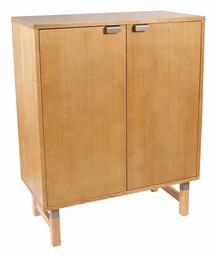

In [15]:
image = Image.open(images_root + "/4c/4cb4ab85.jpg")
image

In [16]:
response = image_search(image, "text_embedding", "text_embedding_closeness")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B07QC864VW,"Amazon Brand – Rivet Mid-Century Console with Self-Closing Drawers, 55""W",0.435115,
1,B0853Q7C48,"Amazon Brand – Rivet Mid-Century Modern Pine Bar Cabinet, 31.5""W, Brown",0.434134,
2,B07B7JY9C5,"Amazon Brand – Rivet Anne Mid-Century Modern Wood Filing Cabinet with Wheels, 20""W, Walnut",0.433873,
3,B07HSH22K8,"Amazon Brand – Rivet Modern Cabinet with Inner Shelf, 15""W, Walnut",0.433558,
4,B000G0PBPI,Strathwood Teak Storage Chest,0.433341,
5,B082JH6LSF,"Amazon Brand – Stone & Beam Mid-Century 2-Drawer File Cabinet, 21.7""W, Pine Finish",0.432911,
6,B0010OY0UQ,Strathwood Sheffield Teak Collection,0.432829,
7,B07B78G1BW,"Amazon Brand – Rivet Ian Mid-Century Modern Wood Buffet Bar Cabinet Credenza, Brown",0.432681,
8,B001BQ1QO6,"Pinzon Capitola Buffet, Cosmo",0.432203,
9,B0010P2QJ2,Strathwood Balboa Collection Parent,0.431646,


In [17]:
response = image_search(image, "synthetic_embedding", "synthetic_embedding_closeness")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B0853Q7C48,"Amazon Brand – Rivet Mid-Century Modern Pine Bar Cabinet, 31.5""W, Brown",0.605431,
1,B082JH6LSF,"Amazon Brand – Stone & Beam Mid-Century 2-Drawer File Cabinet, 21.7""W, Pine Finish",0.565537,
2,B082JGPBLQ,"Amazon Brand – Stone & Beam 2-Drawer Rolling File Cabinet, 15.8""W, Maple Finish",0.563400,
3,B07MNBYN11,AmazonBasics Classic Solid Rubber Wood Rolling Kitchen Cart with Cabinet - Espresso,0.553385,
4,B001BQ1QO6,"Pinzon Capitola Buffet, Cosmo",0.552564,
5,B07Q2MHLH1,AmazonBasics Classic 2-Drawer Wood Nightstand End Table - Cappuccino,0.549679,
6,B07HSH22K8,"Amazon Brand – Rivet Modern Cabinet with Inner Shelf, 15""W, Walnut",0.549633,
7,B07PY8XFFC,AmazonBasics Classic Wood Nightstand End Table with Cabinet - Cappuccino,0.547287,
8,B07L8DMTMS,"Phoenix Home Tilburg Wood End Table with Drawer and Lower Shelf, Forest Oak",0.547026,
9,B07QFB1L2P,"Amazon Brand – Stone & Beam Sumner Modern Filing Cabinet, 21.5""W, White",0.546926,


In [18]:
response = image_search(image, "image_embedding", "image_embedding_closeness")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B0853Q7C48,"Amazon Brand – Rivet Mid-Century Modern Pine Bar Cabinet, 31.5""W, Brown",1.000000,
1,B082JGPBLQ,"Amazon Brand – Stone & Beam 2-Drawer Rolling File Cabinet, 15.8""W, Maple Finish",0.691418,
2,B082JH6LSF,"Amazon Brand – Stone & Beam Mid-Century 2-Drawer File Cabinet, 21.7""W, Pine Finish",0.671923,
3,B07MNBYN11,AmazonBasics Classic Solid Rubber Wood Rolling Kitchen Cart with Cabinet - Espresso,0.658860,
4,B07L492JD2,"Civet Home Rolling Kitchen Cart, Espresso",0.656316,
5,B085565X2N,"Amazon Brand - Rivet Modern Wood Counter-Height Kitchen Bar Stool, 24"" H, Natural",0.655613,
6,B082L28P18,"Amazon Brand – Stone & Beam Modern 2-Drawer File Cabinet with Recessed Metal Handles, 28.5""H, White",0.651258,
7,B003PBOMJ6,"kovalenthor Console Table - Black, for Entryway for Living Room (Grey)",0.650189,
8,B07Q2MHLH1,AmazonBasics Classic 2-Drawer Wood Nightstand End Table - Cappuccino,0.647607,
9,B07MBNM6LY,AmazonBasics Multifunction Rolling Kitchen Cart Island with Open Shelves - Cherry and Black,0.644867,


# ハイブリッド検索

In [19]:
def text_hybrid_search(text, target_field, ranking, query, target_hits=100):
    inputs = processor(text=text, return_tensors="pt", padding=True).to(device)
    query_embedding = model.get_text_features(**inputs).reshape(-1).tolist()
    yql = f"select * from item where userQuery() and ({{targetHits:{target_hits}, approximate:true}}nearestNeighbor({target_field}, query_embedding))"

    with app.syncio() as session:
        response = session.query(
            yql=yql,
            ranking=ranking,
            query=query,
            body = {
                "input.query(query_embedding)": query_embedding
            }
        )
    return response

In [20]:
response = text_hybrid_search("short modern cabinet", "image_embedding", "image_embedding_closeness", "item_name_en_us:black")
show_hits(response)

,item_id,item_name_en_us,relevance,image_html
0,B072ZNPRTC,"Amazon Brand – Rivet King Street Industrial Four-Drawer Media Console Table, Walnut, Black Metal, Glass",0.429690,
1,B07HSF15FW,"Amazon Brand – Rivet Solid Wood Buffet with Wine Rack and Iron Base, 33.86""H, Brushed Natural, Black, Gold",0.429520,
2,B07MM487QZ,"Amazon Brand – Ravenna Home Solid Pine Flat-Topped Headboard - Queen, 65 Inch, Black",0.429440,
3,B07B8NW6C9,"Amazon Brand – Stone & Beam Modern Wood Mirror with Message Board, 30""H, Walnut And Black",0.428350,
4,B07PX3CC31,AmazonBasics Classic Wood Nightstand End Table with Cabinet - Black Oak,0.428035,
5,B07P6QB29Y,"AmazonBasics Classic 70"" Wood TV Stand with Storage Console, Black Oak",0.427984,
6,B07MCCRYNR,"Amazon Brand – Ravenna Home Classic Media Center with Glass-Front Cabinets, 44""W, Black Wood",0.427743,
7,B082Q829YS,"AmazonBasics Extra Wide Fabric 5-Drawer Storage Organizer Unit for Closet, Black (Renewed)",0.427507,
8,B08FGH14HD,"AmazonBasics Fabric 3-Drawer Storage Organizer Unit for Closet, Black (Renewed)",0.427335,
9,B072ZK885L,"Amazon Brand – Rivet King Street Industrial Floating Side Table Night Stand, Walnut, Black Metal, Glass",0.427217,
